In [3]:
%pip install numpy tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

In [6]:
%pip install nltk
%pip install seaborn

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------- ----- 1.3/1.5 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install scikit-learn

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk import pos_tag
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [48]:
df = pd.read_csv("movie_reviews.csv")

In [4]:
tokenizer = nltk.ToktokTokenizer()

#Setting English stopwords
nltk.download('stopwords')
stopword_list=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LINHKHANHSPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
#tokenize the text, remove stopwords and limit word count of each comment
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    #Limit the word count of each review to 150 words
    #filtered_text = filtered_tokens[:150]  
    #filtered_text = ' '.join(filtered_tokens)  
    return filtered_tokens

In [50]:
#Apply function on review column
df['comment']=df['comment'].apply(tokenize)

In [51]:
# try:
#     df.to_csv("movie_reviews_short.csv", index=False) 
#     print("File saved successfully.")
# except Exception as e:
#     print("Error:", e)
print(df.comment.loc[0:1])

0    [original, 1982, theatrical, showing, Beta, vi...
1    [really, believe, one, great, crime, movies, t...
Name: comment, dtype: object


In [18]:
# Lemmatization
# Download required datasets
nltk.download('wordnet')
nltk.download('omw-1.4')  # For multilingual WordNet support
nltk.download('averaged_perceptron_tagger_eng')# For POS tagging

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LINHKHANHSPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LINHKHANHSPC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\LINHKHANHSPC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [52]:
lemmatizer = WordNetLemmatizer()
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
def lemmatize(text):
    pos_tags = pos_tag(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    new_text = ' '.join(lemmatized_words)
    return new_text

df['comment']=df['comment'].apply(lambda text: lemmatize(text))



In [53]:
print(df['comment'])

0       original 1982 theatrical show Beta videotape ,...
1       really believe one great crime movie time. dra...
2       ' say well , stole text : Shallow romance , sh...
3            final scene enough get excite 10th movie : )
4       Megan Fox ..... joke. fluff brains. Totally un...
                              ...                        
1346    earth consider one best ? anyone explain myste...
1347    rate movie look alone?It might look authentic ...
1348    go film think would carry first 2 goal film st...
1349    Context : atheist , one evangelical Christians...
1350    ' listen critic say movie boring. movie one te...
Name: comment, Length: 1351, dtype: object


In [74]:
import re

def remove_things(text):
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
        
    # Remove years
    text = re.sub(r"\b\d{4}\b", "", text)

    # Remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]','',text)
    return text


df['comment']=df['comment'].apply(remove_things)

In [75]:
df.comment.loc[0:0]

0    original  theatrical show Beta videotape  stan...
Name: comment, dtype: object

Term Frequency-Inverse Document Frequency model (TF-IDF)

It is used to convert text documents to matrix of tf-idf features.

In [56]:
#Tfidf vectorizer

def tfidf_vectorize(text):
    tfidf=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3), max_features=10000)
    new_text = tfidf.fit_transform(text)
    print(f"Vocabulary size: {len(tfidf.get_feature_names_out())}")

    return new_text


In [ ]:
text_count_matrix = tfidf_vectorize(df.comment)

Vocabulary size: 10000


In [59]:
print(text_count_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 95695 stored elements and shape (1351, 10000)>
  Coords	Values
  (0, 6512)	0.16191662551802896
  (0, 8707)	0.09854442166006996
  (0, 8045)	0.05028478409910943
  (0, 8331)	0.07840496945232206
  (0, 2331)	0.08022684453875485
  (0, 1097)	0.10069107602935222
  (0, 7459)	0.18405230668550215
  (0, 7686)	0.18405230668550215
  (0, 1048)	0.2447018687861172
  (0, 7535)	0.2447018687861172
  (0, 9447)	0.06726191616380699
  (0, 1774)	0.09495715974366994
  (0, 8828)	0.10472580374689001
  (0, 9484)	0.10968747494858504
  (0, 9427)	0.06845327797840113
  (0, 1846)	0.20265474647320694
  (0, 2072)	0.05347752246830171
  (0, 3248)	0.07392436506837759
  (0, 42)	0.09854442166006996
  (0, 9947)	0.04903646552796612
  (0, 3429)	0.06511526179452475
  (0, 7365)	0.06845327797840113
  (0, 5467)	0.08381410645515487
  (0, 5063)	0.06588705933296592
  (0, 4855)	0.12272789773881318
  :	:
  (1349, 9402)	0.1244546439693504
  (1349, 9859)	0.11941952378688758
  (1

In [60]:
X =text_count_matrix
y = df.sentiment

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


## Naive Bayes

In [70]:
# let's use Naive Bayes classifier and fit our model:
from sklearn.naive_bayes import MultinomialNB 
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
#4. Evaluating the model
from sklearn import metrics
accuracy_score = metrics.accuracy_score(MNB.predict(X_test), y_test)
print("accuracy_score= " + str('{:04.2f}'.format(accuracy_score*100))+" %")

accuracy_score= 60.59 %


In [71]:
y_pred = MNB.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))

[[ 83  48   5]
 [  0 152   2]
 [ 37  68  11]]


## Neural Network

In [ ]:
%pip install tensorflow==2.12

In [79]:
import numpy as np
import tensorflow as tf
import keras
from keras import models

In [80]:
from keras.utils import to_categorical
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [76]:
X_train_dense = X_train.toarray()
y_train_onehot = to_categorical(y_train)

In [78]:
X_test_dense = X_train.toarray()
y_test_onehot = to_categorical(y_train)

In [ ]:
seq_model = keras.Sequential()
#Input layer
seq_model.add(Dense(128, activation='tanh', input_shape=(X_train_dense.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(64, activation='tanh'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(32, activation='tanh'))
seq_model.add(Dropout(0.4))
#Output layer
seq_model.add(Dense(3, activation='softmax')) # <-- Notice activation in final layer.


seq_model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics = ['accuracy'])

In [ ]:
#define batch size and epochs
# Then plot the training and validation loss

history = seq_model.fit(X_train_dense, y_train_onehot,
validation_data = (X_test_dense, y_test_onehot),
epochs= 50,
batch_size = 32)

In [54]:
#evaluate model accuracy
scores = seq_model.evaluate(X_test_dense, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 51.35%


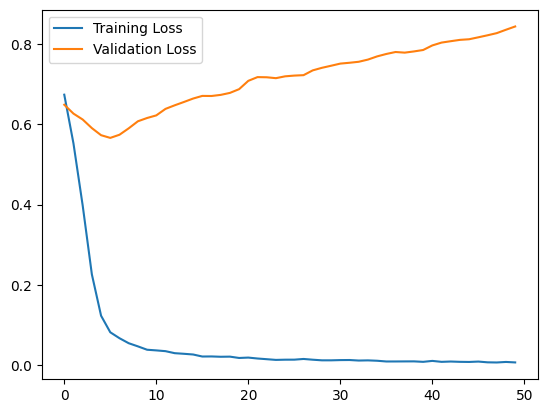

In [55]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

5/5 [==============================] - 0s 30ms/step


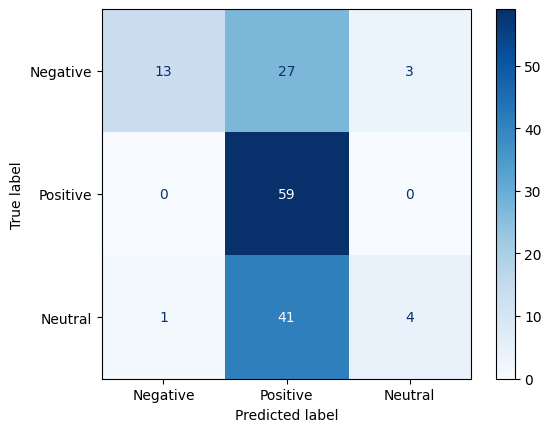

In [58]:
# Step 1: Make Predictions
y_pred_prob = seq_model.predict(X_test_dense)  # Model predictions (probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)  

# Step 2: Convert True Labels (if one-hot encoded)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Step 4: Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive", "Neutral"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
def run_NLP_pipeline(text):
    t1 = tokenize(text)
    t2 = lemmatize(t1)
    t3 = remove_things(t2)
    t4= tfidf_vectorize([t3])
    t5 = t4.toarray()
    return t5

In [ ]:
sentence = ["This is like average."]
sentence_1 = run_NLP_pipeline(sentence)
# Check shape to ensure it's correct
print(f"Shape of input for model: {sentence_1.shape}")


Shape of input for model: (1, 56)


In [ ]:
predictions = seq_model.predict(sentence_1)

# Get the predicted class (index of the max probability)
predicted_class = predictions.argmax(axis=-1)

# Map the index to the label
class_labels = ["Negative", "Positive", "Neutral"]  # Example class labels
predicted_label = class_labels[predicted_class[0]]

# Convert predictions to a dictionary for readability
formatted_predictions = {label: round(prob, 4) for label, prob in zip(class_labels, predictions[0])}
print(f"Probabilities: {formatted_predictions}")

print(f"Predicted Class Index: {predicted_class[0]}")
print(f"Predicted Label: {predicted_label}")

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
# Add custom stopwords
custom_stopwords = set(STOPWORDS)  # Get default stopwords
custom_stopwords.update(["movie", "film", "scene", "character", 
                         "plot", "make", "one", "actor", "see",
                         "watch", "action", "drama"])  # Add domain-specific words
print(custom_stopwords)
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5, stopwords=custom_stopwords)

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=df[df.sentiment == 1].comment
positive_string = ", ".join(positive_text)
positive_words=WC.generate(positive_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

In [ ]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=df[df.sentiment == 0].comment
negative_string = ", ".join(negative_text)
negative_words=WC.generate(negative_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [ ]:
#Word cloud for neutral review words
plt.figure(figsize=(10,10))
neutral_text=df[df.sentiment == 2].comment
neutral_string = ", ".join(neutral_text)
neutral_words=WC.generate(neutral_string)
plt.imshow(neutral_words,interpolation='bilinear')
plt.show